In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy import sqrt
import pandas as pd
import scipy.constants as const
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit                        # Funktionsfit:     popt, pcov = curve_fit(func, xdata, ydata) 
from uncertainties import ufloat                            # Fehler:           fehlerwert =  ulfaot(x, err)
from uncertainties import unumpy as unp 
from uncertainties.unumpy import uarray                     # Array von Fehler: fehlerarray =  uarray(array, errarray)
from uncertainties.unumpy import (nominal_values as noms,   # Wert:             noms(fehlerwert) = x
                                  std_devs as stds)         # Abweichung:       stds(fehlerarray) = errarray

from scipy.stats import norm

Tabelle erstellen:

In [2]:
dscan_data = pd.read_csv('tables/detektorscan.txt', delim_whitespace="\t")
latex_table = dscan_data.to_latex(index=False, column_format="c c", decimal=',', header=[r'$\theta$', r'$I$'], escape=False)
print(latex_table)

\begin{tabular}{c c}
\toprule
$\theta$ &    $I$ \\
\midrule
   -0,30 &   1836 \\
   -0,29 &   2122 \\
   -0,28 &   2236 \\
   -0,27 &   2418 \\
   -0,26 &   2579 \\
   -0,25 &   2644 \\
   -0,24 &   3160 \\
   -0,23 &   3646 \\
   -0,22 &   4368 \\
   -0,21 &   4898 \\
   -0,20 &   5479 \\
   -0,19 &   6142 \\
   -0,18 &   6781 \\
   -0,17 &   7939 \\
   -0,16 &   9296 \\
   -0,15 &  11164 \\
   -0,14 &  13036 \\
   -0,13 &  15916 \\
   -0,12 &  20495 \\
   -0,11 &  26592 \\
   -0,10 &  34614 \\
   -0,09 &  45569 \\
   -0,08 &  60869 \\
   -0,07 &  92128 \\
   -0,06 & 141444 \\
   -0,05 & 198646 \\
   -0,04 & 249182 \\
   -0,03 & 318370 \\
   -0,02 & 392259 \\
   -0,01 & 456486 \\
    0,00 & 506208 \\
    0,01 & 505924 \\
    0,02 & 445386 \\
    0,03 & 351661 \\
    0,04 & 252666 \\
    0,05 & 175980 \\
    0,06 & 124592 \\
    0,07 &  98877 \\
    0,08 &  69837 \\
    0,09 &  52169 \\
    0,10 &  36003 \\
    0,11 &  27611 \\
    0,12 &  22698 \\
    0,13 &  19287 \\
    0,14 &  1789

/tmp/ipykernel_333/1043202770.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = dscan_data.to_latex(index=False, column_format="c c", decimal=',', header=[r'$\theta$', r'$I$'], escape=False)


Daten auswerten:

## X-Scan

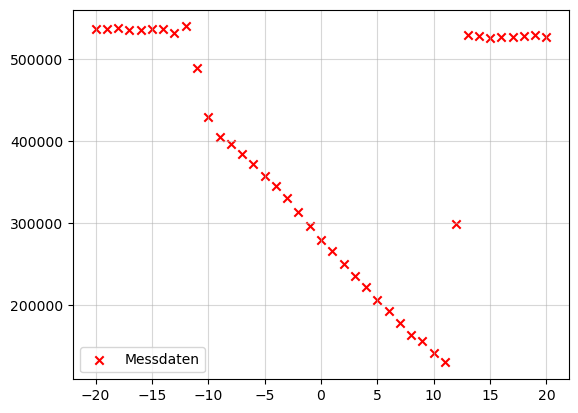

In [3]:
x, Intensity = np.genfromtxt('tables/x_scan1.txt', unpack=True)

fig, ax = plt.subplots()

ax.scatter(x, Intensity, marker='x', c='r', label='Messdaten')
ax.grid('::', alpha=0.5)
ax.legend(loc='best')
plt.show()

## Detektorscan

I_max = 488878.3942458265
FWHM = 0.08632353670031782


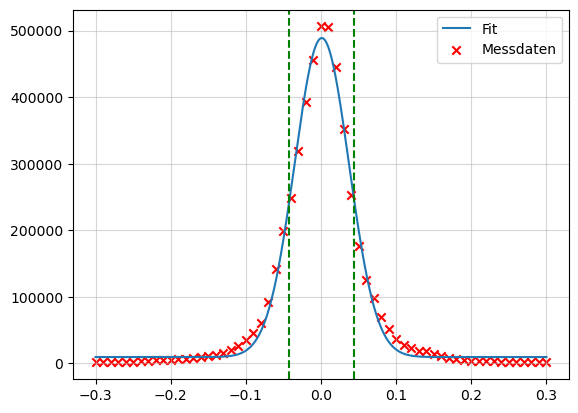

In [4]:
from scipy.optimize import fsolve

theta, I = np.genfromtxt('tables/detektorscan.txt', unpack=True, skip_header=1)

def gauss(theta, A, mean, scale, b):
    return A * norm.pdf(theta, loc=mean, scale=scale) + b

popt, pcov = curve_fit(gauss, theta, I, p0=[10000, 0, 0.1, 1])
A = ufloat(popt[0], np.sqrt(np.diag(pcov))[0])
mean = ufloat(popt[1], np.sqrt(np.diag(pcov))[1])
scale = ufloat(popt[2], np.sqrt(np.diag(pcov))[2])
b = ufloat(popt[3], np.sqrt(np.diag(pcov))[3])

fig, ax = plt.subplots()
x_fit = np.linspace(np.min(theta), np.max(theta), 1000)
ax.plot(x_fit, gauss(x_fit, *popt), label='Fit')
ax.scatter(theta, I, marker='x', c='r', label='Messdaten')


half_max = gauss(noms(mean), *popt) / 2

roots = fsolve(lambda x: gauss(x, *popt) - half_max, x0=[-0.2,0.2])
for root in roots:
    ax.axvline(root, color='g', linestyle='--')

print(f'I_max = {gauss(noms(mean), *popt)}')
print(f'FWHM = {np.abs(roots[1] - roots[0])}')

ax.grid('::', alpha=0.5)
ax.legend(loc='best')
plt.show()

## Z Scan

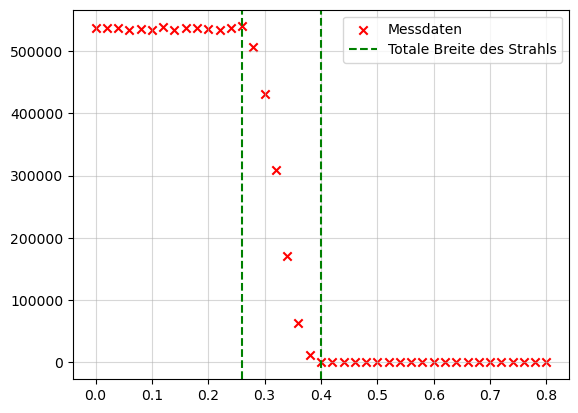

d0=0.140


In [5]:
z, Intensity = np.genfromtxt('tables/z_scan1.txt', unpack=True)

fig, ax = plt.subplots()

ax.scatter(z, Intensity, marker='x', c='r', label='Messdaten')
ax.axvline(z[13], color='g', linestyle='--')
ax.axvline(z[20], color='g', linestyle='--', label='Totale Breite des Strahls')

ax.grid('::', alpha=0.5)
ax.legend(loc='best')
plt.show()

d0 = z[20] - z[13]
print(f'{d0=:.3f}')

## Rockingscan

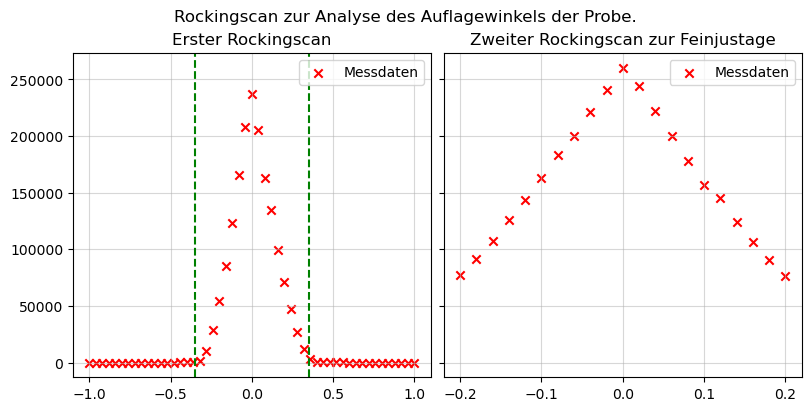

Theoretischer Wert des Geometriewinkels: 0.40107373207253


In [6]:
theta, Intensity = np.genfromtxt('tables/rockingscan_1_3.txt', unpack=True)

fig, ax = plt.subplots(1, 2, figsize=(8,4), layout='constrained', sharey=True)
ax = np.ravel(ax)

ax[0].scatter(theta, Intensity, marker='x', c='r', label='Messdaten')
ax[0].set(
    title='Erster Rockingscan',
)

geomwinkel = 0.35

ax[0].axvline(theta[np.argmax(Intensity)] + geomwinkel, color='g', linestyle='--')
ax[0].axvline(theta[np.argmax(Intensity)] - geomwinkel, color='g', linestyle='--')

theta, Intensity = np.genfromtxt('tables/rockingscan_1_4.txt', unpack=True)
ax[1].scatter(theta, Intensity, marker='x', c='r', label='Messdaten')
ax[1].set(
    title='Zweiter Rockingscan zur Feinjustage',
)

for i, axis in enumerate(ax):
    axis.grid('::', alpha=0.5)
    axis.legend(loc='best')

plt.suptitle('Rockingscan zur Analyse des Auflagewinkels der Probe.')
plt.show()

print(f'Theoretischer Wert des Geometriewinkels: {np.rad2deg(np.arcsin(0.14 / 20))}')

## Messung

In [7]:
theta, Intensity = np.genfromtxt('tables/Messung1.txt', unpack=True)
theta, Intensity1 = np.genfromtxt('tables/Messung2.txt', unpack=True)

In [8]:
# data = np.c_[theta, Intensity, Intensity1]
df = pd.DataFrame(data=np.c_[theta, Intensity, Intensity1])

hea = list([r'$\theta$', r'$I_{normal}$',r'$I_{diffuse}$'])
df_table = df.to_latex(index = False, column_format= "c c c", decimal=',', header=hea, label='tab:messreihe1', caption='Messdaten der normalen und diffusen Messung.', escape=False)
# with open('build/messdaten_myonen_1.txt', 'w') as f:
#     f.write(df_table)

# print(df_table)

/tmp/ipykernel_333/55185976.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_table = df.to_latex(index = False, column_format= "c c c", decimal=',', header=hea, label='tab:messreihe1', caption='Messdaten der normalen und diffusen Messung.', escape=False)


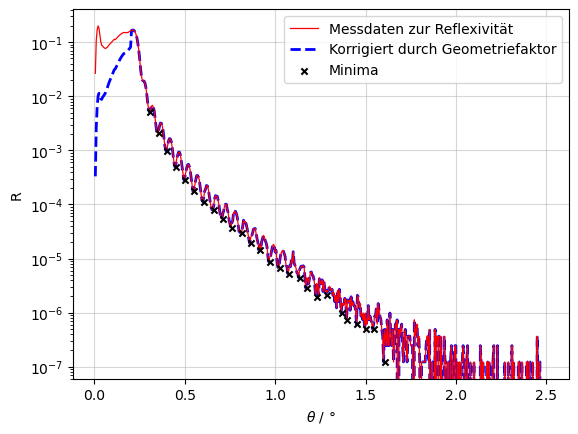

In [80]:
from scipy.signal import argrelextrema
fig, ax = plt.subplots()

def geometriefaktor(theta):
    mask = theta > 0.401 / 2 # geometriewinkel_theo = 0.401, / 2 weil 2theta auf x-achse
    result = np.zeros_like(theta, dtype=float)

    result[mask] = 1
    result[~mask] = 20 * np.sin(np.deg2rad(theta[~mask])) / d0
    return result

R = (Intensity - Intensity1) / (5 * np.max((Intensity - Intensity1)))
R_korrektur =  R * geometriefaktor(theta)
ax.plot(theta[1:], R[1:], ls='-', c='r', label='Messdaten zur Reflexivität', lw = 0.9, zorder=3)
ax.plot(theta[1:], R_korrektur[1:], ls='--', c='b', label='Korrigiert durch Geometriefaktor',lw=2)
ax.grid('::', alpha=0.5)
ax.legend(loc='best')
ax.set(
    yscale='log',
    xlabel=r'$\theta$ / °',
    ylabel='R',
)

minima_indices = argrelextrema(R_korrektur, np.less, order=5)
minima_theta = theta[1:][minima_indices]
minima_R = R_korrektur[minima_indices]

ax.scatter(minima_theta, minima_R, c='black', label='Minima', s=20, marker='x', zorder=5)
ax.legend(loc='best')
plt.show()

### Rechnungen

##### Kiessig Osz. Abstand / Schichtdicke

In [10]:
diff = np.zeros(len(minima_theta) -1)
for i in np.arange(len(minima_theta) - 1):
    diff[i] = minima_theta[i+1] - minima_theta[i]
    diff[i] = np.deg2rad(diff[i])

diff = diff[diff < np.quantile(diff, 0.95)]
diff = ufloat(np.mean(diff), np.std(diff))
print(f'{diff=:}')

d = 1.541e-10 / (2 * diff)
print(f'{d=:}')

diff=0.00095+/-0.00022
d=(8.1+/-1.8)e-08


## Vergleich Plot

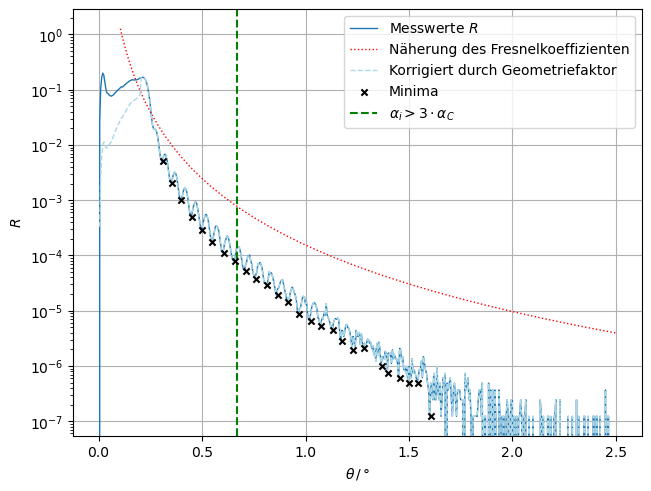

<Figure size 640x480 with 0 Axes>

In [82]:
from scipy.signal import argrelextrema

def geometriefaktor(theta):
    mask = theta > 0.401 / 2 # geometriewinkel_theo = 0.401, / 2 weil 2theta auf x-achse
    result = np.zeros_like(theta, dtype=float)

    result[mask] = 1
    result[~mask] = 20 * np.sin(np.deg2rad(theta[~mask])) / d0
    return result


theta, I  = np.genfromtxt('tables/Messung1.txt', unpack=True)
theta_diff, I_diff  = np.genfromtxt('tables/Messung2.txt', unpack=True)

I_0 = np.max(I - I_diff) * 5         
R_exp = (I - I_diff) / I_0

def fresnelreflectivity(theta):
    """Die Reflektivität für einen Röntgenstrahl der Wellenlänge lam bei
    sehr kleinem Einfallswinkeln an einer Silizium-Oberfläche berechnen.

        Parameters
        ----------
        theta: float
            angle at which the reflectivity is computed

        Returns
        -------
        R(theta): float
           reflectivity at a certain angle theta
    """

    alpha_c = 0.223
    beta = 1.73*10**(-7)

    A_plus = np.sqrt(np.sqrt((theta**2 - alpha_c**2)**2 + 4*beta) + (theta**2 - alpha_c**2)) / np.sqrt(2)
    A_minus = np.sqrt(np.sqrt((theta**2 - alpha_c**2)**2 + 4*beta) - (theta**2 - alpha_c**2)) / np.sqrt(2)

    return ((theta - A_plus)**2 + A_minus**2) / ((theta + A_plus)**2 + A_minus**2)
    
def fresnelreflectivity2(theta):
    alpha_c = 0.223
    return (alpha_c / (2 * theta))**4

fig, ax = plt.subplots(layout='constrained')
ax.plot(theta,
        R_exp,
        linestyle='-',
        linewidth=1,
        label = r'Messwerte $R$',
        )
# ax.plot(theta,
#         fresnelreflectivity(theta),
#         linestyle='--',
#         linewidth=1,
#         label = 'Berechnete Fresnelreflektivität\neiner idealen Si-Schicht',
#         )
ax.plot(theta[theta > 0.1],
        fresnelreflectivity2(theta[theta > 0.1]),
        linestyle=':',
        linewidth=1,
        c='r',
        label = r'Näherung des Fresnelkoeffizienten',
        )
R_korrektur =  R_exp * geometriefaktor(theta)
ax.plot(theta[1:], R_korrektur[1:], ls='--', c='lightblue', label='Korrigiert durch Geometriefaktor',lw=1)

minima_indices = argrelextrema(R_korrektur, np.less, order=5)
minima_theta = theta[1:][minima_indices]
minima_R = R_korrektur[minima_indices]

ax.scatter(minima_theta, minima_R, c='black', label='Minima', s=20, marker='x', zorder=5)

ax.axvline(3 * 0.223, color='g', linestyle='--', label=r'$\alpha_i > 3 \cdot \alpha_C$')
ax.set(
    xlabel = r'$\theta \, / \, °$',
    ylabel = r'$R$',
    yscale = 'log',
)
ax.legend(loc = 'best')
ax.grid('::')
# plt.savefig('plots/Messung1.pdf')
plt.show()
plt.clf()

Schichtdicke: (1.2996+/-0.4875)e-09


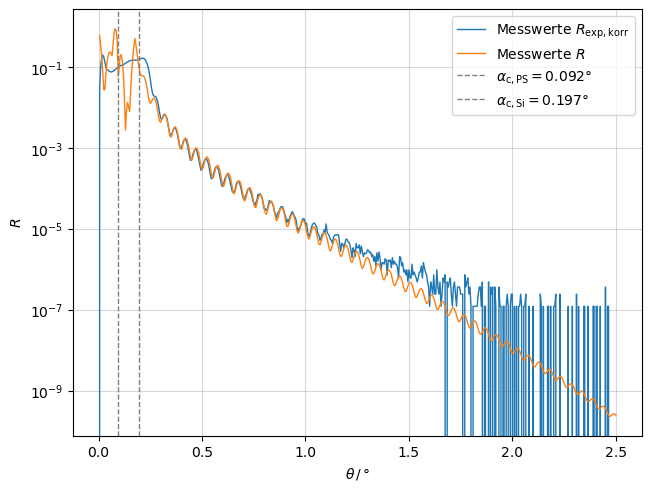

d = 8.502316305881714e-08 ± 2.768170610628988e-10
delta_2 = 9.968211727385963e-07 ± 1.0161633295438957e-08
delta_3 = 4.695562197540003e-06 ± 1.7318805920634702e-08
sigma_1 = 9.223480508962975e-10 ± 1.3235601826375598e-10
sigma_2 = 8.156831904496592e-10 ± 4.4301768967525514e-11

alpha_c_PS=0.092
alpha_c_Si=0.197


In [268]:
lam = 1.541* 10**(-10)
diff = np.zeros(len(minima_theta) -1)
for i in np.arange(len(minima_theta) - 1):
    diff[i] = minima_theta[i+1] - minima_theta[i]

diff = ufloat(np.mean(diff), np.std(diff))

d = lam / (2 * diff)
print('Schichtdicke: {:.4e}'.format(d))

d = 8.62*10**(-8)
delta_2 = 1.3 * 10**(-6)
delta_3 = 5.9 * 10**(-6)
sigma_1 = 8 * 10**(-10)
sigma_2 = 6.5 * 10**(-10)

p0 = ([d, delta_2, delta_3, sigma_1, sigma_2])

def parratt_algorithm(theta, d, delta_2, delta_3, sigma_1, sigma_2):
    k = 2*np.pi/lam

    n_1 = 1
    n_2 = 1 - delta_2 + 1j * delta_2 / 200
    n_3 = 1 - delta_3 + 1j * delta_3 / 40
    
    k_z1 = k * np.sqrt(np.abs(n_1**2 - np.cos(np.deg2rad(theta))**2))
    k_z2 = k * np.sqrt(np.abs(n_2**2 - np.cos(np.deg2rad(theta))**2))
    k_z3 = k * np.sqrt(np.abs(n_3**2 - np.cos(np.deg2rad(theta))**2))

    r_1 = np.exp(-2 * k_z1 * k_z2 * sigma_1**2) * (k_z1 - k_z2) / (k_z1 + k_z2)
    r_2 = np.exp(-2 * k_z2 * k_z3 * sigma_2**2) * (k_z2 - k_z3) / (k_z2 + k_z3)

    X_2 = np.exp(-2j*k_z2 * d) * r_2
    X_1 = (r_1 + X_2) / (1 + r_1 * X_2)

    R = np.abs(X_1)**2

    return R

fit_mask = (theta > 0.3)
# fit_mask = ((theta > 0.05) & (theta<1.5))
params_parratt, cov_parratt = curve_fit(parratt_algorithm,
                                        theta[fit_mask],
                                        R[fit_mask],
                                        p0=p0,
                                        bounds=([10**-9, 10**-7, 10**-7, 10**-10, 10**-10], [10**-7, 10**-5, 10**-5, 10**-9, 10**-9]),
                                        maxfev=100000)

alpha_c_PS = np.rad2deg(np.sqrt(2*delta_2))
alpha_c_Si = np.rad2deg(np.sqrt(2*delta_3))

fig, ax = plt.subplots(layout='constrained')
ax.plot(theta,
        R,
        linestyle='-',
        linewidth=1,
        label = r'Messwerte $R_{\mathrm{exp,korr}}$',
        )
ax.plot(theta[1:],
        parratt_algorithm(theta[1:], *params_parratt),
        linestyle='-',
        linewidth=1,
        label = r'Messwerte $R$',
        )
ax.axvline(alpha_c_PS,
            color='gray',
            linestyle='--',
            linewidth=1,
            label=r'$\alpha_{\mathrm{c,PS}} = $' + f'{alpha_c_PS:=.3f}°',
            )
ax.axvline(alpha_c_Si,
            color='gray',
            linestyle='--',
            linewidth=1,
            label=r'$\alpha_{\mathrm{c,Si}} = $' + f'{alpha_c_Si:=.3f}°',
            )
ax.set(
    xlabel = r'$\theta \, / \, °$',
    ylabel = r'$R$',
    yscale='log',
)
ax.legend(loc = 'best')
ax.grid('::', alpha=0.5)
# plt.savefig('plots/messung2.pdf')
plt.show()

uncertainties = np.sqrt(np.diag(cov_parratt))
for name, value, uncertainty in zip(('d', 'delta_2','delta_3', 'sigma_1', 'sigma_2'), params_parratt, uncertainties): 
    print(f'{name} = {value} ± {uncertainty}')

print()
print(f'{alpha_c_PS=:.3f}')
print(f'{alpha_c_Si=:.3f}')